![alt text](header.png)

### ML-based model compression 

#### Libraries

In [16]:
import os
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

## Tensorflow + Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

## Quantization
from qkeras import *

## Datasets
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Enable GPU 

In [17]:
# GPU
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

import tensorflow as tf
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

GPUs:  1


#### Load dataset

In [18]:
# Cargar dataset MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0            # Normalización

##### Label selection for the binary classification

Filter images that only contain numbers 1 and 9


In [19]:
train_filter = np.where((y_train == 1) | (y_train == 9))
test_filter = np.where((y_test == 1) | (y_test == 9))

x_train = x_train[train_filter]
y_train = y_train[train_filter]
x_test = x_test[test_filter]
y_test = y_test[test_filter]

In [20]:
# Labels to binary format
y_train_binary = np.where(y_train == 1, 0, 1)  # 1 -> 0, 9 -> 1
y_test_binary = np.where(y_test == 1, 0, 1)  # 1 -> 0, 9 -> 1

In [21]:
# One-hot Encoding
y_train_binary = to_categorical(y_train_binary, num_classes=2, dtype=int)
y_test_binary = to_categorical(y_test_binary, num_classes=2, dtype=int)

### Model definition

The architecture is defined in a quantized manner

In [22]:

def build_model():
    # Fixed point precision
    kernelQ = "quantized_bits(8,3,alpha=1)"
    biasQ = "quantized_bits(8, 3,alpha=1)"
    activationQ = 'quantized_bits(16,6)'

    modelQ = Sequential(
                [   
                    
                    QDense(5, name='fc1_input',
                            input_shape=(28 * 28,),
                            kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                            kernel_initializer='lecun_uniform'),
                    QActivation(activation= activationQ ,  name='relu_input'),

                    QDense(7, name='fc1',
                            kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                            kernel_initializer='lecun_uniform'),
                    QActivation(activation= activationQ ,  name='relu1'),

                    QDense(10, name='fc2',
                            kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                            kernel_initializer='lecun_uniform'),
                    QActivation(activation= activationQ ,  name='relu2'),
                    
                    QDense(2, name='output',
                            kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                            kernel_initializer='lecun_uniform'),
                    Activation(activation='sigmoid', name='sigmoid')
                
                ],

            )
    return modelQ



In [23]:
x_train = x_train.reshape(x_train.shape[0], 28 * 28)
x_test = x_test.reshape(x_test.shape[0], 28 * 28)

### Build model

In [24]:
modelQ = build_model()

In [25]:
modelQ.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1_input (QDense)           (None, 5)                 3925      
_________________________________________________________________
relu_input (QActivation)     (None, 5)                 0         
_________________________________________________________________
fc1 (QDense)                 (None, 7)                 42        
_________________________________________________________________
relu1 (QActivation)          (None, 7)                 0         
_________________________________________________________________
fc2 (QDense)                 (None, 10)                80        
_________________________________________________________________
relu2 (QActivation)          (None, 10)                0         
_________________________________________________________________
output (QDense)              (None, 2)                

### Pruning strategy

In [26]:
final_sparsity = 0.2

pruning_params = {
                'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0, final_sparsity=final_sparsity, begin_step=0, end_step=3000
                )
            }

model_QP = tfmot.sparsity.keras.prune_low_magnitude(modelQ, **pruning_params)

/tools/anaconda3/envs/neuralEnv/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [ ]:
lr = 0.00001
op = Adam(lr)
loss = "categorical_crossentropy"
metrics = ["accuracy"]
epochs=32
batch_size=128

model_QP.compile(optimizer=op, loss=loss, metrics=metrics)
h = model_QP.fit(x_train, y_train_binary, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test_binary),callbacks = [tfmot.sparsity.keras.UpdatePruningStep()])

Epoch 1/32
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (

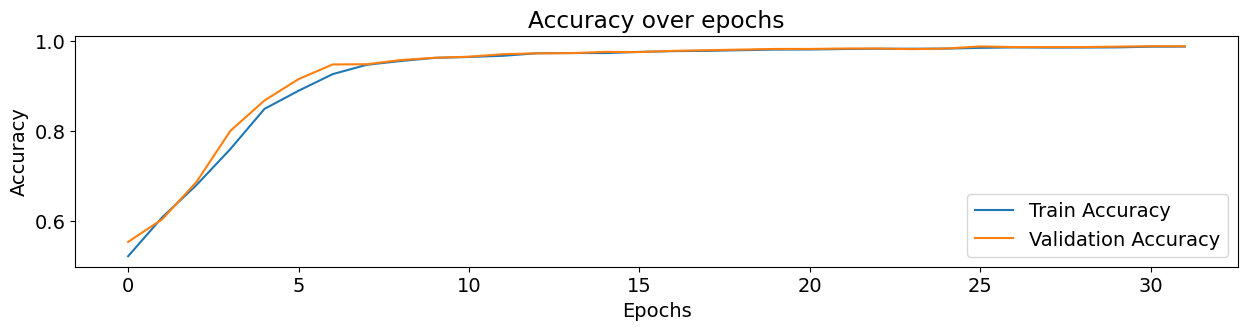

In [28]:
# Plot accuracy over epochs
plt.figure(figsize=(15,3))
plt.plot(h.history['accuracy'], label='Train Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

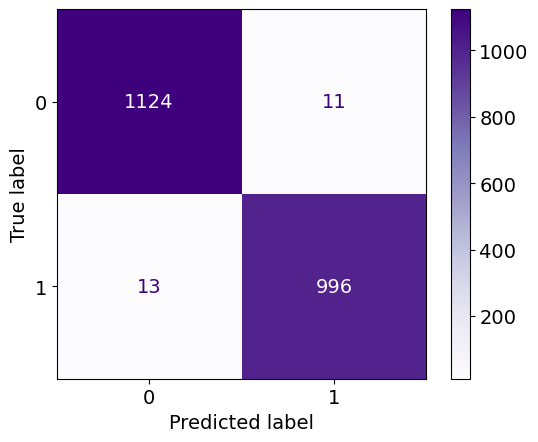

In [29]:
plt.rcParams.update({'font.size': 14})

y_pred_probs = model_QP.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(y_test_binary, axis=1)  # Convert one-hot encoded labels to class indices


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.show()


In [ ]:
model_KD = strip_pruning(model_QP)
model_KD.save("models/mnistPQKD.h5")

---
#### Mar del Plata, Argentina - 2025

Romina Soledad Molina, Ph.D. - MLab/STI ICTP, Trieste, Italy